In [7]:
import pymodis
import os
import warnings
import matplotlib.pyplot as plt
import numpy.ma as ma
import xarray as xr
import rioxarray as rxr
from shapely.geometry import mapping, box
import geopandas as gpd
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep
import rasterio
from rasterio.warp import reproject, Resampling
import georaster
import cartopy.crs as ccrs
from mpl_toolkits.basemap import Basemap
import numpy as np
from matplotlib.colors import Normalize
from sentinelsat import SentinelAPI, read_geojson, geojson_to_wkt
import folium
from folium import plugins
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from meteostat import Point, Daily

In [8]:
import math


def get_tile(lat_geographic, lon_geographic):
    if lat_geographic < -90 or lat_geographic > 90:
        raise ValueError("lat_geographic should be in range of [-90, 90]")
    if lon_geographic < -180 or lon_geographic > 180:
        raise ValueError("lon_geographic should be in range of [-180, 180]")

    lat_tile = lat_geographic
    lon_tile = lon_geographic * math.cos(math.radians(lat_geographic))

    vertical_tile = int((90 - lat_tile) / 10)
    horizontal_tile = int((lon_tile + 180) / 10)
    line = -(lat_tile - 90 + vertical_tile * 10) * 120 - 0.5
    sample = (180 - horizontal_tile * 10 + lon_tile) * 120 - 0.5

    return vertical_tile, horizontal_tile, round(line, 8), round(sample, 8)

# MODIS DATA CONVERT TO TIFF + READ FIRE DATA


In [9]:
# Configuration settings
username = "yann9999999"
password = "npW'sQw7VE)SX+Q"

start_date = "2021-06-29"
end_date = "2021-08-30"

lat_lon = (51.70059156998173, -119.69954537268181)

output_dir = "data"


tiles = get_tile(lat_lon[0], lat_lon[1])

print("Downloading MODIS data for tiles h{0:02}v{1:02}".format(tiles[0], tiles[1]))

downloader = pymodis.downmodis.downModis(
    destinationFolder=output_dir,
    user=username,
    password=password,
    today=start_date,
    enddate=end_date,
    product="MOD14A1.061",
    path="MOLT",
    tiles="h{0:02}v{1:02}".format(tiles[0], tiles[1]),
    debug=True,
)
# downloader.connect()
# downloader.downloadsAllDay(allDays=False)

In [18]:
files = os.listdir(output_dir)

# Loop through all the files, read them using rasterio catch the dates
dates = []
for files in files:
    if files.endswith(".hdf"):
        file_open = rxr.open_rasterio(output_dir + "/" + files)
        dates.append(file_open.attrs["DAYSOFYEAR"])
        print("File: {0} Date: {1}".format(files, file_open.attrs["DAYSOFYEAR"]))

File: MOD14A1.A2021233.h03v10.061.2021243200321.hdf Date: 2021-08-21, 2021-08-22, 2021-08-23, 2021-08-24, 2021-08-25, 2021-08-26, 2021-08-27, 2021-08-28
File: MOD14A1.A2021209.h03v10.061.2021218010823.hdf Date: 2021-07-28, 2021-07-29, 2021-07-30, 2021-07-31, 2021-08-01, 2021-08-02, 2021-08-03, 2021-08-04
File: MOD14A1.A2024121.h03v10.061.2024131205148.hdf Date: 2024-04-30, 2024-05-01, 2024-05-02, 2024-05-03, 2024-05-04, 2024-05-05, 2024-05-06, 2024-05-07
File: MOD14A1.A2021241.h03v10.061.2021251140847.hdf Date: 2021-08-29, 2021-08-30, 2021-08-31, 2021-09-01, 2021-09-02, 2021-09-03, 2021-09-04, 2021-09-05
File: MOD14A1.A2021217.h03v10.061.2021226022825.hdf Date: 2021-08-05, 2021-08-06, 2021-08-07, 2021-08-08, 2021-08-09, 2021-08-10, 2021-08-11, 2021-08-12
File: MOD14A1.A2024113.h03v10.061.2024122054509.hdf Date: 2024-04-22, 2024-04-23, 2024-04-24, 2024-04-25, 2024-04-26, 2024-04-27, 2024-04-28, 2024-04-29
File: MOD14A1.A2021193.h03v10.061.2021202174157.hdf Date: 2021-07-12, 2021-07-13, 

In [36]:
# try to read the tiff file

tiff_file = rxr.open_rasterio(
    "/Users/yannderre/Desktop/DS53-Kaggle/data/modis/MOD14A1.A2021185.h14v03.061.2021194012533.hdf"
)

In [38]:
tiff_file.FireMask

<xarray.DataArray 'FireMask' (band: 8, y: 1200, x: 1200)> Size: 12MB
[11520000 values with dtype=uint8]
Coordinates:
  * band         (band) int64 64B 1 2 3 4 5 6 7 8
  * x            (x) float64 10kB -4.447e+06 -4.446e+06 ... -3.336e+06
  * y            (y) float64 10kB 6.671e+06 6.67e+06 ... 5.561e+06 5.56e+06
    spatial_ref  int64 8B 0
Attributes:
    legend:        Classes:\n0 missing input data\n1 not processed (obsolete)...
    valid_range:   0, 9
    _FillValue:    0
    scale_factor:  1.0
    add_offset:    0.0

In [55]:
# reproject the file
tiff_file = tiff_file.rio.reproject("EPSG:4326")

In [58]:
tiff_file.FireMask.shape

(8, 488, 1625)

In [3]:
# Put all the modis files in a 4D array where the first dimension is the time


def stack_big_modis(path):
    files = os.listdir(path)
    files = [f for f in files if f.endswith(".hdf")]
    files = sorted(files)
    data = []
    for f in files:
        tiff_file = rxr.open_rasterio(f"{path}/{f}")
        tiff_file = tiff_file.rio.reproject("EPSG:4326")
        data.append(tiff_file.FireMask.data)
    return np.array(data)

In [4]:
big_modis = stack_big_modis(output_dir)

In [5]:
big_modis.shape

(8, 8, 488, 1625)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
# for every pixel in big_modis, we want to get the geographical coordinates


In [5]:
warnings.simplefilter("ignore")

# Get the MODIS data
et.data.get_data("cold-springs-modis-h4")

# This download contains the fire boundary
et.data.get_data("cold-springs-fire")

# Set working directory
os.chdir(os.path.join(et.io.HOME, "earth-analytics", "data"))

In [4]:
# Open data with rioxarray
modis_pre = rxr.open_rasterio(
    "/Users/yannderre/Desktop/DS53-Kaggle/MOD14A1.A2021209.h10v03.061.2021218013045.hdf"
)

type(modis_pre)

xarray.core.dataset.Dataset

In [6]:
modis_pre

<xarray.Dataset> Size: 92MB
Dimensions:      (band: 8, x: 1200, y: 1200)
Coordinates:
  * band         (band) int64 64B 1 2 3 4 5 6 7 8
  * x            (x) float64 10kB -8.895e+06 -8.894e+06 ... -7.784e+06
  * y            (y) float64 10kB 6.671e+06 6.67e+06 ... 5.561e+06 5.56e+06
    spatial_ref  int64 8B 0
Data variables:
    FireMask     (band, y, x) uint8 12MB ...
    QA           (band, y, x) uint8 12MB ...
    MaxFRP       (band, y, x) int32 46MB ...
    sample       (band, y, x) uint16 23MB ...
Attributes: (12/84)
    ALGORITHMPACKAGEACCEPTANCEDATE:     04-2006
    ALGORITHMPACKAGEMATURITYCODE:       Normal
    ALGORITHMPACKAGENAME:               MOD_PR14A
    ALGORITHMPACKAGEVERSION:            5
    ASSOCIATEDINSTRUMENTSHORTNAME.1:    MODIS
    ASSOCIATEDPLATFORMSHORTNAME.1:      Terra
    ...                                 ...
    TileID:                             51010003
    UnknownPix:                         0, 0, 0, 0, 1, 14, 2, 5
    VERSIONID:                          61
    VERTICALTILENUMBER:                 3
    VerticalTileNumber:                 3
    WESTBOUNDINGCOORDINATE:             -159.99999995957

BoundingBox(left=-159.99999995956395, bottom=49.99775546067685, right=-108.91491668041758, top=59.99999999461182)


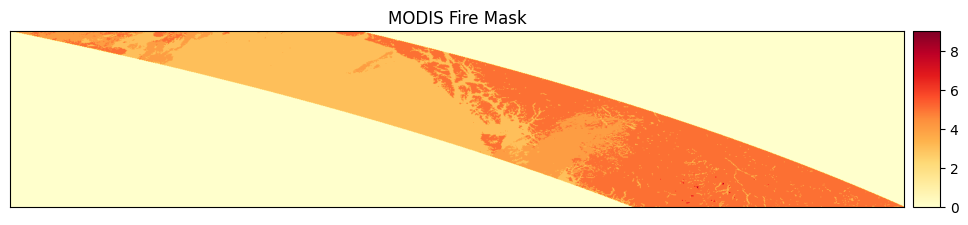

<Axes: title={'center': 'MODIS Fire Mask'}>

In [18]:
# Open data with rioxarray
modis_pre = rxr.open_rasterio(
    "/Users/yannderre/Desktop/DS53-Kaggle/MOD14A1.A2021209.h10v03.061.2021218013045.hdf"
)

modis_pre

# Convert the projection of the data
# print(modis_pre.rio.crs)

modis_pre.FireMask.rio.write_nodata(0, inplace=True)

modis_pre = modis_pre.FireMask.rio.reproject("EPSG:4326")

# print(modis_pre.rio.crs)


# Export the data
modis_pre.rio.to_raster(
    "/Users/yannderre/Desktop/DS53-Kaggle/MOD14A1.A2021209.h10v03.061.2021218013045.tif"
)

# Open the data with rasterio
modis_pre_2 = rasterio.open(
    "/Users/yannderre/Desktop/DS53-Kaggle/MOD14A1.A2021209.h10v03.061.2021218013045.tif"
)

modis_pre_2.profile

print(modis_pre_2.bounds)

# Plot the data
ep.plot_bands(modis_pre_2.read(1), cmap="YlOrRd", title="MODIS Fire Mask", scale=False)

## Rasterize modis_pre_2 to png with only the values 9

In [ ]:
# read the first

In [11]:
# create a 4D array tensor containing (time, widht, lon, features)
# the feature contains the 9 masks of the modis_pre_2
# split the 9 values contained into modis_ore_2



(326, 1665)

In [8]:
# Fire coordinates finder
coords = []

for i in range(0, modis_pre_2.read(1).shape[0]):
    for j in range(0, modis_pre_2.read(1).shape[1]):
        if modis_pre_2.read(1)[i, j] == 9:
            # Printing the coordinates of the pixel =9
            print("Fire Pixel at: ", modis_pre_2.xy(i, j))
            # Store the coordinates of the pixel =9
            coords.append(modis_pre_2.xy(i, j))


# Create a map centered on the mean of the coordinates
m = folium.Map(zoom_start=10)

# Add the coordinates to the map
for coord in coords:
    folium.Marker(location=[coord[1], coord[0]]).add_to(m)

# Display the map
m

Fire Pixel at:  (-119.69954537268181, 51.70059156998173)
Fire Pixel at:  (-121.57113100633222, 51.363092521290675)
Fire Pixel at:  (-121.54044927463303, 51.363092521290675)
Fire Pixel at:  (-119.30068286059239, 51.332410789591485)
Fire Pixel at:  (-119.2700011288932, 51.332410789591485)
Fire Pixel at:  (-119.33136459229158, 51.3017290578923)
Fire Pixel at:  (-119.30068286059239, 51.3017290578923)
Fire Pixel at:  (-119.2700011288932, 51.3017290578923)
Fire Pixel at:  (-118.93250208020214, 51.17900213109555)
Fire Pixel at:  (-120.74272425045417, 51.11763866769718)
Fire Pixel at:  (-120.74272425045417, 51.08695693599799)
Fire Pixel at:  (-118.93250208020214, 50.81082135070531)
Fire Pixel at:  (-118.90182034850295, 50.81082135070531)
Fire Pixel at:  (-121.1109050308444, 50.62673096051019)
Fire Pixel at:  (-121.08022329914522, 50.62673096051019)
Fire Pixel at:  (-121.04954156744604, 50.62673096051019)
Fire Pixel at:  (-119.82227229947856, 50.31991364351832)
Fire Pixel at:  (-121.23363195764

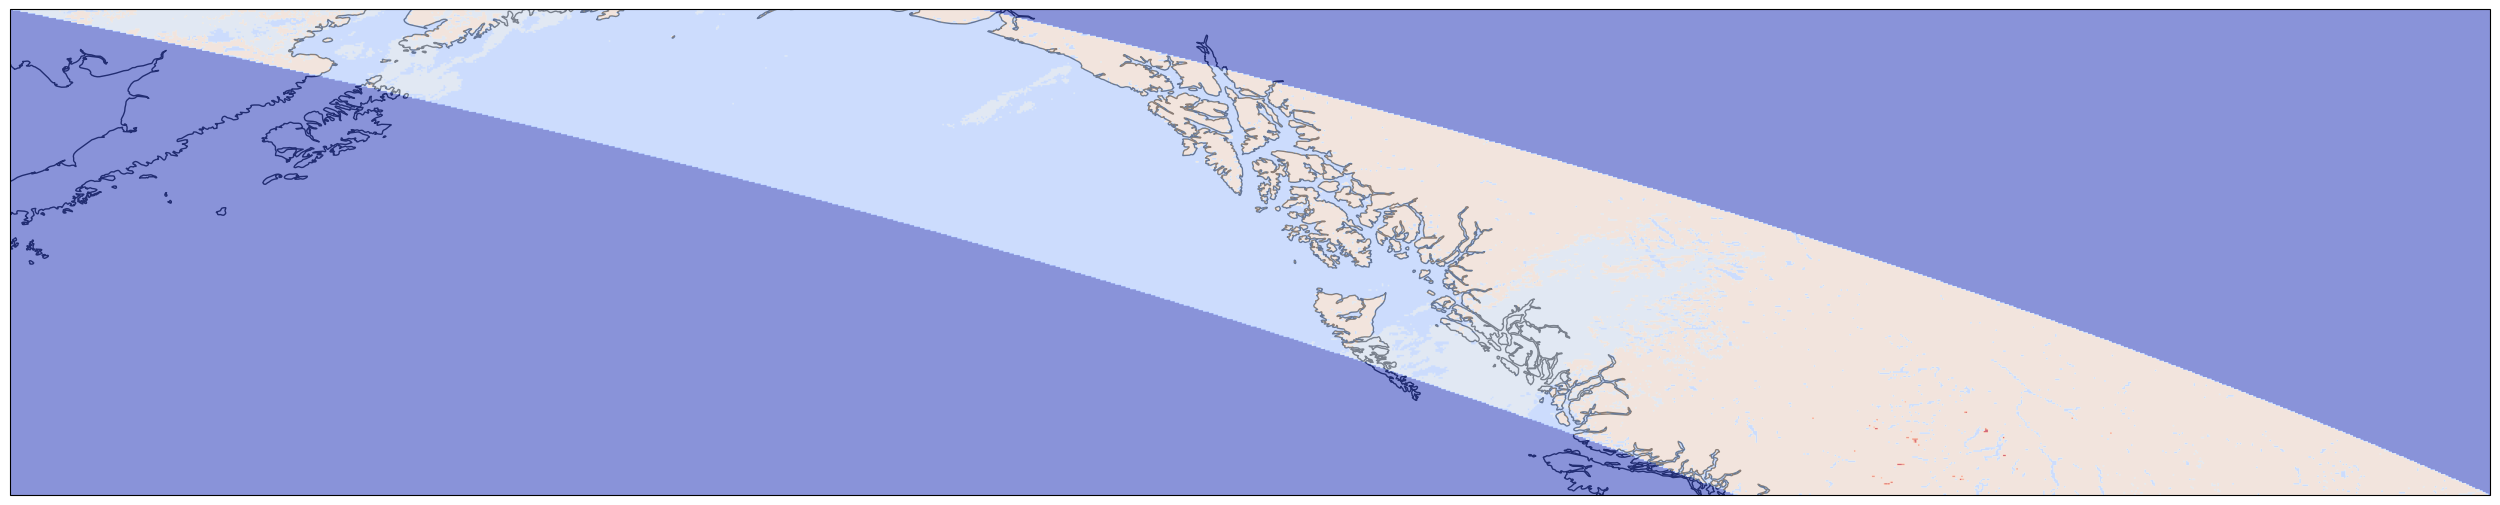

In [5]:
# Open the GeoTIFF file
image_path = (
    "/Users/yannderre/Desktop/DS53-Kaggle/MOD14A1.A2021209.h10v03.061.2021218013045.tif"
)
image = georaster.SingleBandRaster(image_path, latlon=True)

# Create a figure and axis with PlateCarree projection
fig = plt.figure(figsize=(32, 32))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

# Plot the GeoTIFF data
plt.imshow(
    image.r,
    extent=image.extent,
    transform=ccrs.PlateCarree(),
    zorder=2,
    alpha=0.6,
    cmap="coolwarm",
)

# Add coastlines and gridlines
ax.coastlines()

# Show the plot
plt.show()

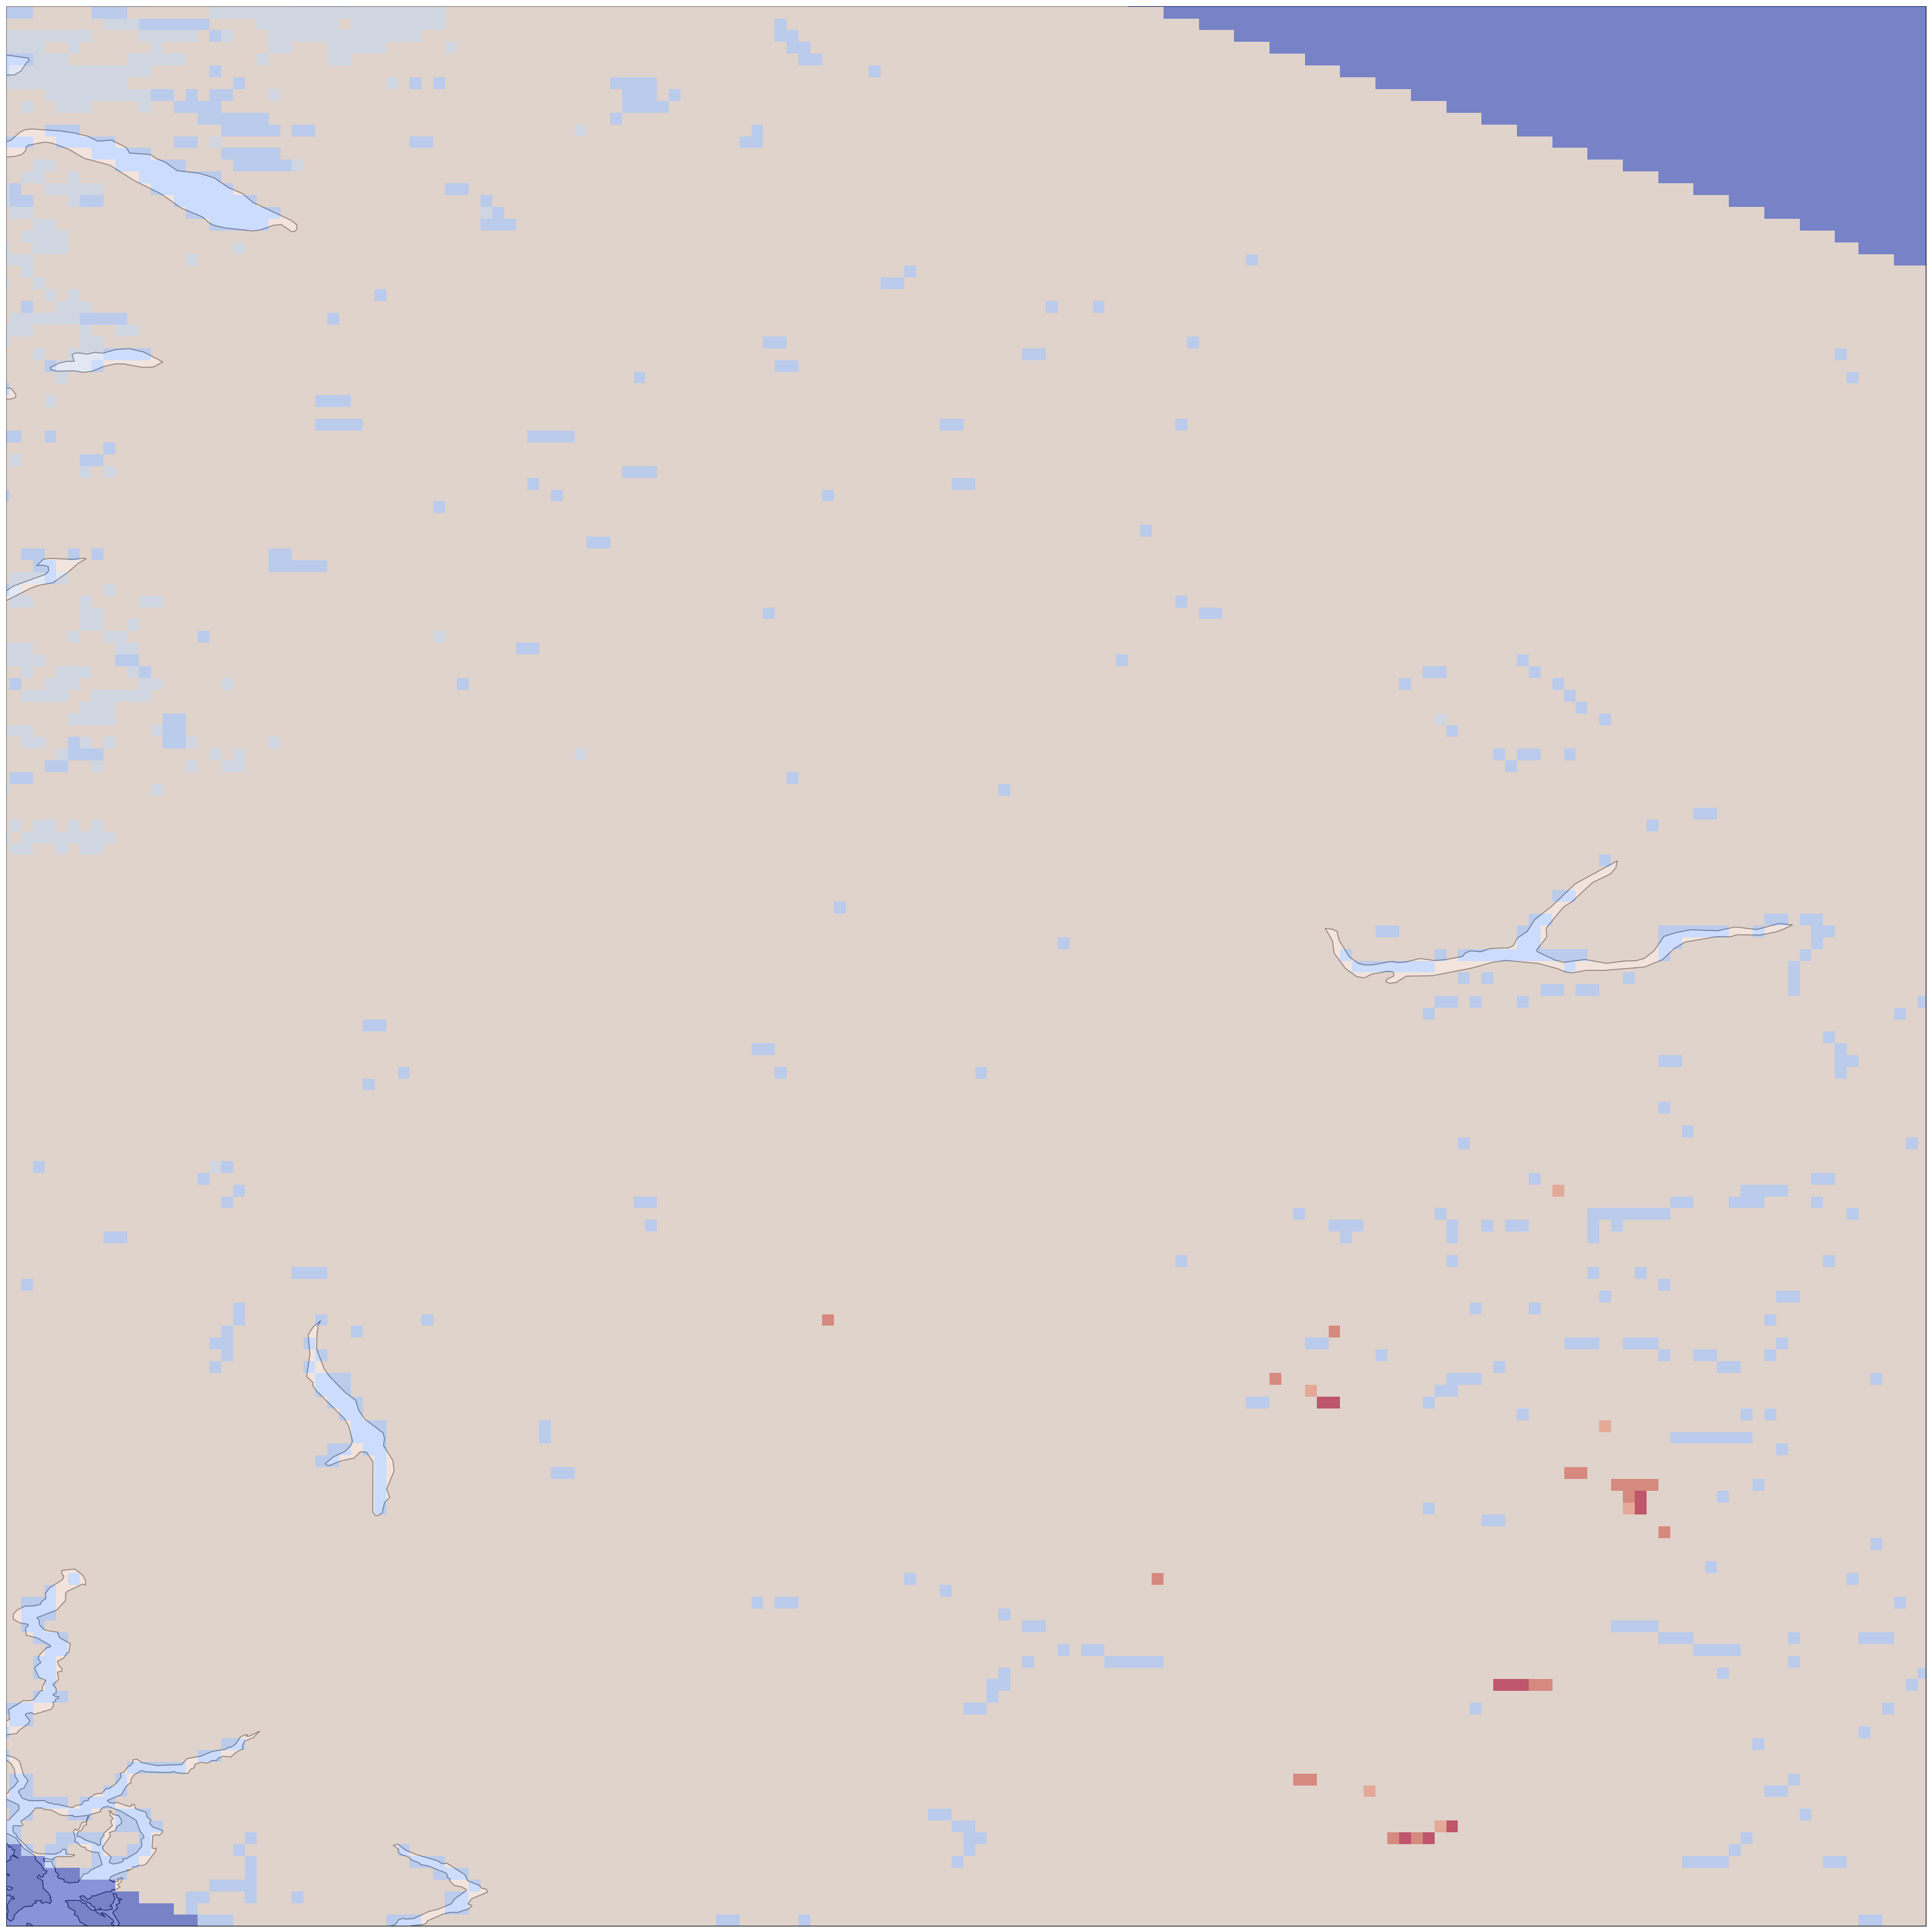

In [6]:
fig = plt.figure(figsize=(40, 40))

m = Basemap(
    projection="cyl",
    lon_0=-134,
    lat_0=55,
    llcrnrlat=50,
    urcrnrlat=55,
    llcrnrlon=-125,
    urcrnrlon=-120,
    resolution="h",
)

m.drawcoastlines()
m.fillcontinents(color="lightgray")

image = georaster.SingleBandRaster(
    "/Users/yannderre/Desktop/DS53-Kaggle/MOD14A1.A2021209.h10v03.061.2021218013045.tif",
    latlon=False,
)

# Calculate the center of the image
center_lon = (image.extent[0] + image.extent[1]) / 2
center_lat = (image.extent[2] + image.extent[3]) / 2

plt.imshow(
    image.r, extent=image.extent + (2, 2, 2, 2), zorder=10, alpha=0.6, cmap="coolwarm"
)

plt.show()

In [16]:
modis_pre = rxr.open_rasterio(
    "/Users/yannderre/Desktop/DS53-Kaggle/MOD14A1.A2021209.h10v03.061.2021218013045.tiff"
)
modis_pre.rio.bounds()

(-159.99999995956395,
 49.99775546067685,
 -108.91491668041758,
 59.99999999461182)

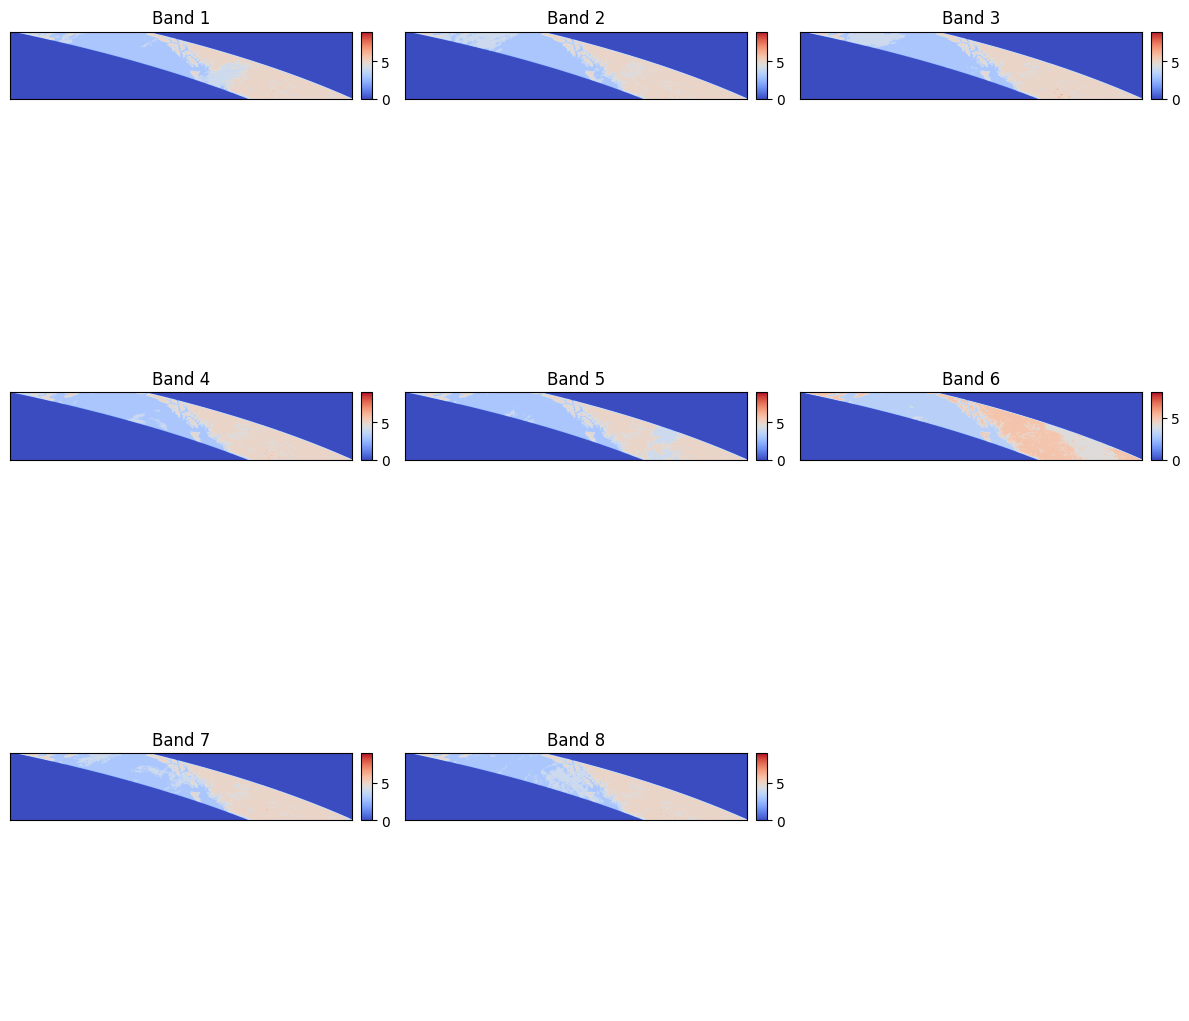

In [27]:
# for every band use a color map from black to blue to red
ep.plot_bands(modis_pre, cmap="coolwarm", scale=False)
plt.show()

# DOWNLOAD WEATHER DATA

In [54]:
## Invert the coordinates of coords, put the second element first and the first element second
coords = [(coord[1], coord[0]) for coord in coords]

# Create a df with the coords
df = pd.DataFrame(coords, columns=["latitude", "longitude"])

# Print the 2nd row
print(df.iloc[1])

latitude    -121.571131
longitude     51.363093
Name: 1, dtype: float64


In [1]:
# Set time period
start = datetime(2021, 7, 28)
end = datetime(2021, 8, 10)

# Create a point
coords2 = [Point(coord[1], coord[0]) for coord in coords]


for point in coords2:
    # print the index of the point in the dataframe
    print("Point index: ", coords2.index(point))
    # Get daily data
    data = Daily(point, start, end)
    data = data.fetch()

    if data.empty:
        continue
    # Put the corresponding coords in the legend

    data.plot(y=["tavg", "tmin", "tmax"])
    # Name the plot after the coords corresponding to the point index inside df dataframe
    plt.title(f"Temperature for coords: {df.iloc[coords2.index(point)]}")
    plt.show()

    # Plot the wind direciton data for the point
    data.plot(y=["wdir", "wspd"])
    plt.title(f"Wind for coords: {df.iloc[coords2.index(point)]}")
    plt.show()

    # Plot precipitation data for the point
    data.plot(y=["prcp"])
    plt.title(f"Precipitation for coords: {df.iloc[coords2.index(point)]}")
    plt.show()

    print(data)

NameError: name 'datetime' is not defined

# Getting sentinel data

In [8]:
from sentinelhub import SHConfig
import os

# copernicus User email
SH_CLIENT_ID = os.getenv("yann.derre44@gmail.com")
# copernicus User Password
SH_CLIENT_SECRET = os.getenv("7n93&?8g4Mue-'f")

config = SHConfig()
config.instance_id = "73e5c956-6189-4353-a41a-bf5c8e05f26f"
config.sh_client_id = "yann.derre44@gmail.com"
config.sh_client_secret = "7n93&?8g4Mue-'f"
config.sh_base_url = "https://sh.dataspace.copernicus.eu"
config.sh_token_url = "https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token"

print(config)
if config.instance_id == "":
    print(
        "Warning! To use OGC functionality of Sentinel Hub, please configure the `instance_id`."
    )

{
  "instance_id": "********************************f26f",
  "sh_client_id": "******************.com",
  "sh_client_secret": "***********e-'f",
  "sh_base_url": "https://sh.dataspace.copernicus.eu",
  "sh_auth_base_url": null,
  "sh_token_url": "https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token",
  "geopedia_wms_url": "https://service.geopedia.world",
  "geopedia_rest_url": "https://www.geopedia.world/rest",
  "aws_access_key_id": "",
  "aws_secret_access_key": "",
  "aws_session_token": "",
  "aws_metadata_url": "https://roda.sentinel-hub.com",
  "aws_s3_l1c_bucket": "sentinel-s2-l1c",
  "aws_s3_l2a_bucket": "sentinel-s2-l2a",
  "opensearch_url": "http://opensearch.sentinel-hub.com/resto/api/collections/Sentinel2",
  "max_wfs_records_per_query": 100,
  "max_opensearch_records_per_query": 500,
  "max_download_attempts": 4,
  "download_sleep_time": 5.0,
  "download_timeout_seconds": 120.0,
  "number_of_download_processes": 1,
  "max_retries": null
}

In [9]:
from sentinelhub import CRS, BBox, DataCollection, MimeType, WcsRequest, WmsRequest
import datetime
import matplotlib.pyplot as plt
import numpy as np
import imageio

In [10]:
def plot_image(image, factor=1):
    """
    Utility function for plotting RGB images.
    """
    plt.subplots(nrows=1, ncols=1, figsize=(15, 7))

    if np.issubdtype(image.dtype, np.floating):
        plt.imshow(np.minimum(image * factor, 1))
    else:
        plt.imshow(image)

In [11]:
landiras_coords_wgs84 = (-0.55, 44.57, -0.48, 44.52)
landiras_bbox = BBox(bbox=landiras_coords_wgs84, crs=CRS.WGS84)
landiras_bbox
start_date = datetime.datetime(2022, 7, 12)
end_date = datetime.datetime(2022, 8, 14)
data_collection = DataCollection.SENTINEL2_L1C
layer = "NDVI"

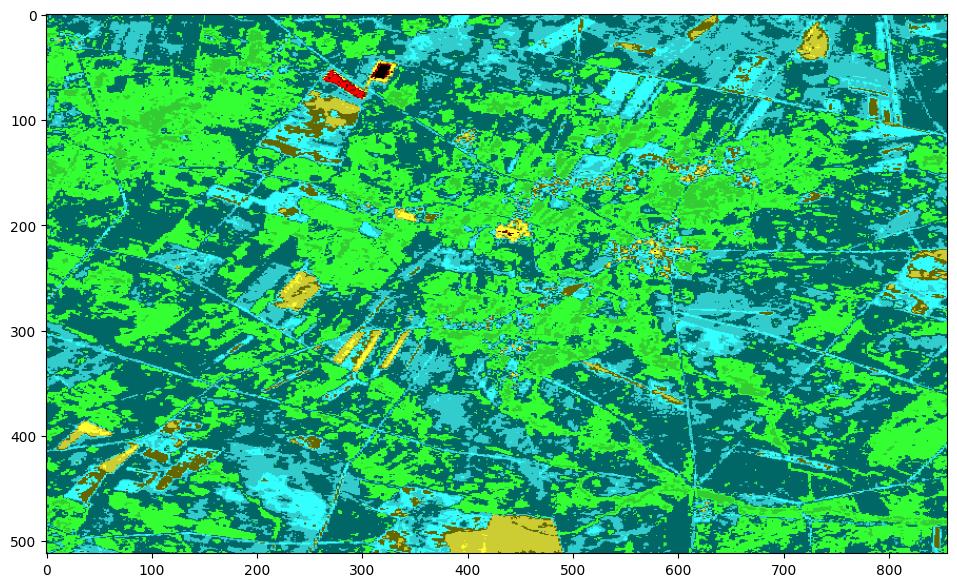

In [12]:
# visualize the area of interest
date_str = start_date.strftime("%Y-%m-%d")
wms_request = WmsRequest(
    data_collection=data_collection,
    layer=layer,
    bbox=landiras_bbox,
    time=date_str,
    width=856,
    height=512,
    config=config,
)
wms_image = wms_request.get_data()
if len(wms_image) > 1:
    plot_image(wms_image[-1])

In [13]:
img_array = []

# Loop through dates
current_date = start_date
while current_date <= end_date:
    date_str = current_date.strftime("%Y-%m-%d")
    wms_request = WmsRequest(
        data_collection=data_collection,
        layer=layer,
        bbox=landiras_bbox,
        time=date_str,
        width=856,
        height=512,
        config=config,
    )
    wms_img = wms_request.get_data()
    current_date += datetime.timedelta(days=1)
    if len(wms_image) > 0:
        img_array.append(wms_image[-1])

In [14]:
print("Returned images: %d." % (len(img_array)))

Returned images: 34.


In [15]:
# simple gif
filename = "landiras.gif"
with imageio.get_writer(filename, mode="I", duration=1000) as writer:
    for image in img_array:
        writer.append_data(image)

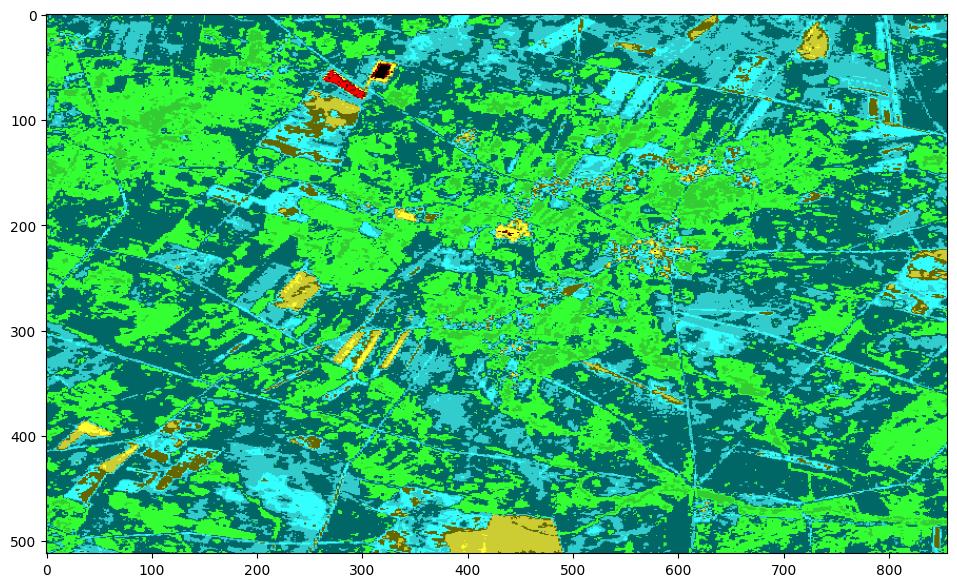

In [16]:
plot_image(img_array[1])

In [17]:
# Filter the red pixels
def filter_red(image, threshold=0.3):
    """
    Filter red pixels in the image.
    """
    red = image[:, :, 0]
    green = image[:, :, 1]
    blue = image[:, :, 2]
    mask = (red - green) / (red + green + blue + 1e-10) > threshold
    image[mask] = 0
    return image

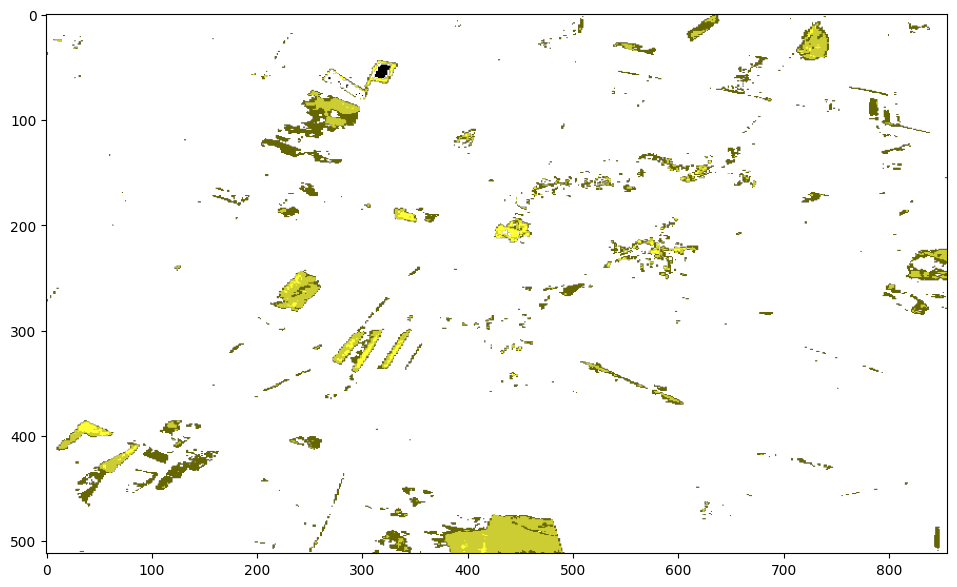

In [18]:
plot_image(filter_red(img_array[1].copy()))

# Creating the tensor

In [ ]:
import numpy as np

# Define the directory where your resized tensors are stored
data_directory = "path_to_save_downloaded_data"

# Assuming you have a list of file paths for the resized tensors
file_paths = [...]

# Load each tensor and organize them into sequences
sequences = []
for file_path in file_paths:
    tensor = np.load(file_path)  # Load the resized tensor
    sequences.append(tensor)

# Convert the list of sequences into a numpy array
sequences = np.array(sequences)

# Add a new dimension to represent different locations/sequences
# This will create a 5-dimensional tensor
sequences = np.expand_dims(sequences, axis=0)

print("Shape of the combined tensor:", sequences.shape)

# Creating the model

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D,
    ConvLSTM2D,
    BatchNormalization,
    TimeDistributed,
    Flatten,
    Dense,
)

# Define the ConvLSTM model
model = Sequential(
    [
        # Convolutional LSTM layer with 32 filters, kernel size of (3, 3), and 'same' padding
        ConvLSTM2D(
            filters=32,
            kernel_size=(3, 3),
            padding="same",
            return_sequences=True,
            input_shape=(None, 128, 128, 3),
        ),
        BatchNormalization(),  # Batch normalization layer for normalization
        # Another Convolutional LSTM layer with 64 filters
        ConvLSTM2D(
            filters=64, kernel_size=(3, 3), padding="same", return_sequences=True
        ),
        BatchNormalization(),
        # Convolutional layer with 128 filters and kernel size of (3, 3)
        TimeDistributed(
            Conv2D(filters=128, kernel_size=(3, 3), activation="relu", padding="same")
        ),
        # Flatten layer to convert 2D output to 1D
        TimeDistributed(Flatten()),
        # Dense layer with 256 units
        TimeDistributed(Dense(256, activation="relu")),
        # Output layer with softmax activation for classification
        TimeDistributed(Dense(1, activation="softmax")),
    ]
)

# Compile the model
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Print model summary
model.summary()

/Users/yannderre/Desktop/DS53-Kaggle/.conda/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_lstm2d (ConvLSTM2D)        │ (None, None, 128, 128, │        40,448 │
│                                 │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, None, 128, 128, │           128 │
│ (BatchNormalization)            │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_1 (ConvLSTM2D)      │ (None, None, 128, 128, │       221,440 │
│                                 │ 64)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, None, 128, 128, │           256 │
│ (BatchNormalization)            │ 64)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, None, 128, 128, │        73,856 │
│ (TimeDistributed)               │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, None, 2097152)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, None, 256)      │   536,871,168 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, None, 1)        │           257 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 537,207,553 (2.00 GB)

 Trainable params: 537,207,361 (2.00 GB)

 Non-trainable params: 192 (768.00 B)

In [2]:
predictions = model.predict(sequences)

# Iterate through each sample in the predictions
for sample_idx, sample_predictions in enumerate(predictions):
    # Iterate through each sequence in the sample
    for sequence_idx, sequence_predictions in enumerate(sample_predictions):
        # Create a new figure for the sequence
        plt.figure(figsize=(10, 6))
        plt.suptitle(f"Sample {sample_idx + 1}, Sequence {sequence_idx + 1}")

        # Iterate through each day in the sequence
        for day, prediction in enumerate(sequence_predictions):
            # Plot the prediction as an image
            plt.subplot(2, 3, day + 1)  # Adjust subplot layout as needed
            plt.imshow(prediction, cmap="viridis")  # Adjust cmap as needed
            plt.title(f"Day {day + 1}")
            plt.colorbar()
            plt.axis("off")

        # Adjust layout and display the figure
        plt.tight_layout()
        plt.show()

NameError: name 'sequences' is not defined

In [ ]:
num_future_days = 5  # Adjust as needed

# Make predictions for future days
future_predictions = []
for sample_idx, sample_predictions in enumerate(predictions):
    future_sample_predictions = []
    for sequence_predictions in sample_predictions:
        # Get the last day's prediction from the sequence
        last_day_prediction = sequence_predictions[-1]
        # Predict future days beyond the last day
        for _ in range(num_future_days):
            # Predict the next day using the last day's prediction
            next_day_prediction = model.predict(
                np.expand_dims(last_day_prediction, axis=0)
            )
            # Append the predicted next day to the sequence
            future_sample_predictions.append(next_day_prediction[0])
            # Update the last day's prediction for the next iteration
            last_day_prediction = next_day_prediction[0]
    # Append future predictions for the sample
    future_predictions.append(future_sample_predictions)

# Convert future predictions to numpy array
future_predictions = np.array(future_predictions)

In [ ]:
# Define the number of future days to plot
num_future_days = 5  # Adjust as needed

# Iterate through each sample in the predictions
for sample_idx, sample_predictions in enumerate(predictions):
    # Iterate through each sequence in the sample
    for sequence_idx, sequence_predictions in enumerate(sample_predictions):
        # Create a new figure for the sequence
        plt.figure(figsize=(10, 6))
        plt.suptitle(f"Sample {sample_idx + 1}, Sequence {sequence_idx + 1}")

        # Plot the original sequence
        for day, prediction in enumerate(sequence_predictions):
            plt.subplot(2, num_future_days + 1, day + 1)
            plt.imshow(prediction, cmap="viridis")  # Adjust cmap as needed
            plt.title(f"Day {day + 1}")
            plt.colorbar()
            plt.axis("off")

        # Plot the future predictions
        for future_day, future_prediction in enumerate(
            future_predictions[sample_idx, sequence_idx]
        ):
            plt.subplot(2, num_future_days + 1, num_future_days + 1 + future_day)
            plt.imshow(future_prediction, cmap="viridis")  # Adjust cmap as needed
            plt.title(f"Future Day {future_day + 1}")
            plt.colorbar()
            plt.axis("off")

        # Adjust layout and display the figure
        plt.tight_layout()
        plt.show()